In [1]:
import numpy as np
import matplotlib.pyplot as plt
N=64 # number of time steps
A0 = np.load('As.npy')
noise0 = np.load('Ns.npy')/np.sqrt(16) # 16 samples notch integration
karin = np.load('kar.npy')
M = len(karin)
kar =np.outer(np.arange(N), karin)

In [2]:
precompensation = np.load('precompensation.npz')['precomp'][90:90+410]
precompensation /= precompensation.sum()
antenna = 1/np.copy(precompensation)
freq=(karin*50e3)/1e6

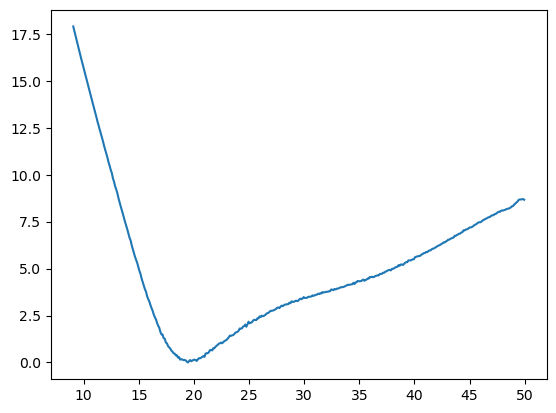

In [3]:
plt.plot(freq,np.log10(precompensation/precompensation.min())*10)

In [4]:
precompensation_fix = np.copy(precompensation)
precompensation_fix[freq<15]*=0.01
precompensation_fix[freq>25]*=0.01
precompensation_fix/=precompensation_fix.sum()


410.0 1402.5278905582443


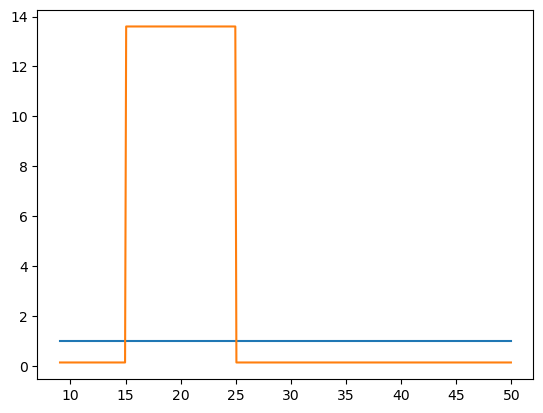

In [5]:
plt.plot(freq,precompensation*antenna)
plt.plot(freq,precompensation_fix*antenna)
print ((precompensation*antenna).sum(),(precompensation_fix*antenna).sum())

In [6]:
A0fix = A0*np.sqrt(precompensation_fix*antenna)

In [7]:
def generate_data (sig = 1e-3, A=0.1*np.ones(M), noise =1 *np.ones(M)):
    phi_ofs = np.random.uniform(0,2*np.pi,M)
    n = (np.random.normal (0, 1/np.sqrt(2),(N,M))+1j*np.random.normal(0,1/np.sqrt(2),(N,M)) ) *noise[None,:]
    s = A*np.exp(1j*(phi_ofs[None,:]+kar*sig))
    return s+n

def estimate_phi (data,A = None, noise = None, fds=False):
    sum0 = np.sum(data,axis=0)
    sum0x = (np.abs((data[::2]-data[1::2])**2).sum(axis=0))
    SNR2 = np.abs(sum0**2)/sum0x
    sum1 = (data*kar*1j).sum(axis=0)
    sum2 = (-data*kar**2).sum(axis=0)
    
    FD = np.real(sum0*np.conj(sum1))
    SD = np.real(sum2*np.conj(sum0)+sum1*np.conj(sum1))
    if (fds):
        return FD, SD, SNR2

    if A is None:
        return FD.sum()/SD.sum()
    else:
        weights = A**2/noise**4
        return (FD*weights).sum()/(SD*weights).sum()
    

def get_error (sig, A, noise, Ngo=100000):
    res = [estimate_phi(generate_data(sig, A,noise),A,noise) for i in range(Ngo)]
    res = np.array(res)
    mean = res.mean()
    std = res.std()
    return mean, std

def SNR(A, noise):
    SNR2 = (A**2/noise**2).sum()*N
    return np.sqrt(SNR2)


In [8]:
def var_phi(sig, A, noise, Ngo):
    fdsd = np.array([estimate_phi(generate_data(sig, A,noise),fds=True) for i in range(Ngo)])
    fd = fdsd[:,0]
    sd = fdsd[:,1]
    snr2 = fdsd[:,2]
    #plt.plot(sd.sum(axis=1),fd.sum(axis=1),'b.')
    res = fd.sum(axis=1)/sd.sum(axis=1)
    opt_we = (A**2)/(0.5*noise**2*(noise**2+A**2*N))
    print(snr2)
    snr = np.sqrt(snr2.sum(axis=1))
    print (opt_we.min(), opt_we.max())
    res_opt = (fd*opt_we[None,:]).sum(axis=1)/(sd*opt_we[None,:]).sum(axis=1)

    #fd_mean_pred = -A**2*sig*((kar**2).sum()*N-np.outer(kar,kar).sum())
    #sd_mean_pred = np.array([-A[k]**2*((kar[:,k]**2).sum()*N-np.outer(kar[:,k],kar[:,k]).sum()) for k in range(M)])
    #print (sd.mean()/sd_mean_pred)
    #sigma=1
    #fdvarprednn = sigma**4*0.5*(N*(kar**2).sum()-np.outer(kar,kar).sum())
    #fdvarprednC = 0.5*np.abs(A**2)*sigma**2*(kar**2).sum()*N**2
    #fdvarpredCn = 0.5*np.abs(A**2)*sigma**2*(np.outer(kar,kar)).sum()*N
    #fd_var_pred = fdvarprednn+fdvarprednC-fdvarpredCn
    #K1 = N*(kar**2).sum()
    #K2 = np.outer(kar,kar).sum()
    #invar = A**2/(0.5*noise**2*(noise**2+A**2*N))*np.abs(sd_mean_pred)
    #err2_pred1 = 1/invar
    #print (invar)
    #resi = (fd/sd).mean(axis=0)
    #resiv = (fd/sd).var(axis=0)
    #invar = 1/resiv# A**2/noise**4
    #res_opt2 = (fd/sd*invar[None,:]).sum(axis=1)/invar.sum()
    #print (resiv)
    #print(1/invar)


    #err2_pred = fd_var_pred/sd_mean_pred**2
    #print (err2_pred, err2_pred1)
    #print (fd.var(), sd.var())
    #print (fd_var_pred, fd.var()/fd_var_pred,'<<')
    #print (res.mean(), res.var(), fd.var()/sd.mean()**2, fd_var_pred/sd_mean_pred**2, res.var()/err2_pred)
    #plt.plot(res)
    plt.plot(res_opt)
    print(res_opt.min(), res_opt.max())
    #plt.hist(res_opt)
    return res.mean(), res.var(), res_opt.mean(), res_opt.var(), snr.mean(), snr.std()#fd.var()/sd.mean()**2, fd_var_pred/sd_mean_pred**2, res.var()/err2_pred


SNR: 26.486756716241665
[[1.0287017  1.05183503 1.33803414 ... 0.53556378 2.03327704 0.5373425 ]
 [2.39001022 0.61699782 1.6643081  ... 0.44604476 4.09248476 3.25205771]
 [0.89013948 1.39424754 0.3960569  ... 0.69711626 2.04013206 0.66957952]
 ...
 [0.03194908 0.69348324 0.53630738 ... 0.54108881 0.10442181 0.13601948]
 [0.90901681 0.82404892 3.46114672 ... 1.67414394 0.43487595 1.18890792]
 [0.92219141 0.9501489  0.31148744 ... 0.32700905 0.69497669 1.06554353]]
160864892465.3429 20301819492211.17
-1.2314862357491383e-05 1.348052591589021e-05


(-3.36575406775462e-07,
 7.059852701074211e-11,
 5.331592911267104e-08,
 1.4331522765263036e-11,
 33.859889267858755,
 0.6858758103491315)

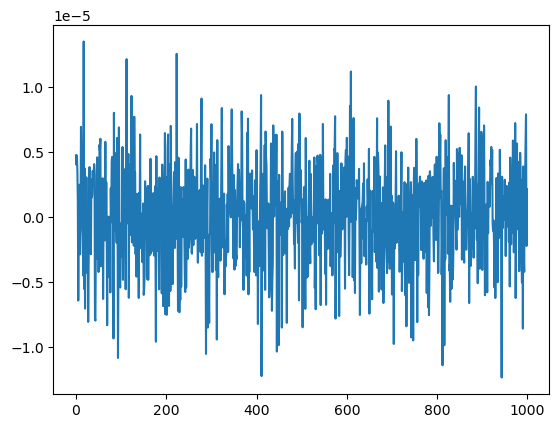

In [9]:
A=A0fix
sig=0
noise = noise0
print ('SNR:', SNR(A, noise))

var_phi(sig, A, noise,1000)

In [10]:
A=A0fix
noise = noise0
L = 1/kar.max()*7
sigl = np.linspace(-L,L,100)
print (SNR(A, noise))
s,e = np.array([get_error(sig, A, noise,100) for sig in sigl]).T

26.486756716241665


(-0.00011122233344455566, 0.00011122233344455566)

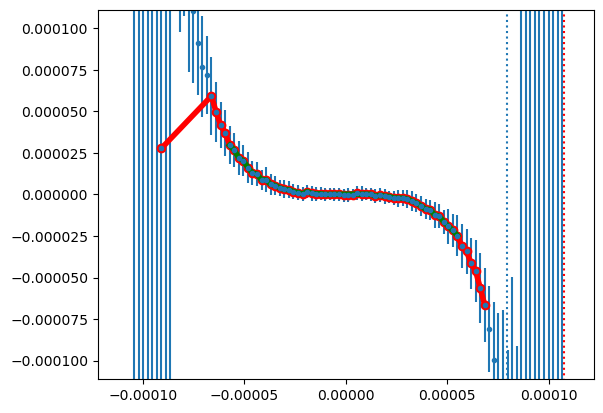

In [11]:
w = np.where(np.abs(sigl-s)<np.abs(sigl))
w2 = np.where(np.abs(sigl-s)+2*np.abs(e)<np.abs(sigl))
plt.errorbar(sigl,sigl-s,yerr=e,fmt='.')
plt.plot(sigl[w],sigl[w]-s[w],'ro-',lw=4)
plt.plot(sigl[w2],sigl[w2]-s[w2],'g-',lw=4)
plt.axvline(5/kar.max(),-1,1,ls=':')
plt.axvline(2/kar.mean(),-1,1,ls=':',color='r')
plt.ylim(-L,L)

(1.5888904777793666e-05, 0.0, 1.0)

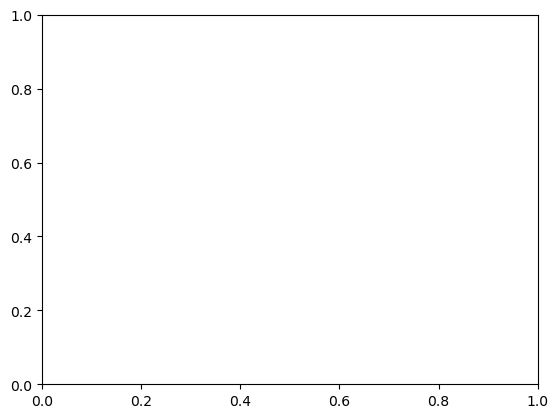

In [12]:
1/kar.max(),plt.ylim()[0],plt.ylim()[1]